In a quant interview last year, I was asked a question about the tradeoff in changing the number of folds $k$ in $k$-fold cross-validation. Obviously, as the number of folds increases, the model is fit on a subset that is closer to the full dataset size $n$. And if I recall correctly, the interviewer implied was that the variance should be decreasing as the number of folds increases. This seemed weird to me, even though averaging more samples is typically thought to reduce variance. 

After mulling it over a bit, I realized what I couldn't put my finger on during the interview. Even though the test samples are always independent across folds, the fitted models become increasingly correlated as the number of folds increases. In the case of $k=2$ we have independent models since they are trained on disjoint samples. However, by the time we get to $k=n$, each model is trained on almost the same samples. Thus, there is an aspect of increasing correlation between folds as the number of folds increases, and depending on its strength could mitigate the variance reduction of averaging them.

Let's test this in some simple examples.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

In [2]:
np.random.seed(1)

In [3]:
## params
n = 200
p = 10
beta = np.random.uniform(-1,1, size=(p))
snr = 1. 
niter = 500

In [4]:
## generate data
def gen_data(n, beta, snr):
    p = len(beta)
    X = np.random.randn(n,p)
    # beta = np.random.uniform(-1, 1, size=(p))

    mu = X @ beta
    sigma = np.sqrt(np.var(mu)/snr)

    y = mu + sigma * np.random.randn(n)

    return X, y, sigma

In [5]:
def compute_cv_est(n, beta, snr, model, cv):
    # errs = 0
    errs = np.zeros(cv.n_splits)
    X, y, _ = gen_data(n, beta, snr)
    for i, (tr_idx, ts_idx) in enumerate(cv.split(X)):
        X_tr = X[tr_idx,:]
        y_tr = y[tr_idx]

        X_ts = X[ts_idx,:]
        y_ts = y[ts_idx]

        model.fit(X_tr,y_tr)
    
        # errs += np.sum((y_ts - model.predict(X_ts))**2)
        errs[i] = np.mean((y_ts - model.predict(X_ts))**2)

    # return errs / n
    return errs.mean()

In [6]:
def get_mc_err(n, beta, snr, niter, model):
    mc_errs = np.zeros(niter)
    for i in range(niter):
        X,  y, sigma = gen_data(n, beta, snr)
        model.fit(X, y)
        Xt, yt, _ = gen_data(1, beta, snr)
        mc_errs[i] = (yt - model.predict(Xt))[0]**2

    return mc_errs.mean()

In [7]:
## MC simulation: Linear model
ks = [2,10] + [25*i for i in range(1,n//25)] + [n]
K = len(ks)

lm = LinearRegression(fit_intercept=False)

lm_cv_errs = np.zeros((niter, K))
for j, k in enumerate(ks):
    print(f"Iter:{j}, {k=}")
    cv = KFold(n_splits=k)
    for i in range(niter):
        lm_cv_errs[i,j] = compute_cv_est(n, beta, snr, lm, cv)

Iter:0, k=2
Iter:1, k=10
Iter:2, k=25
Iter:3, k=50
Iter:4, k=75
Iter:5, k=100
Iter:6, k=125
Iter:7, k=150
Iter:8, k=175
Iter:9, k=200


In [8]:
lm_mc_err = get_mc_err(n, beta, snr, niter, lm)

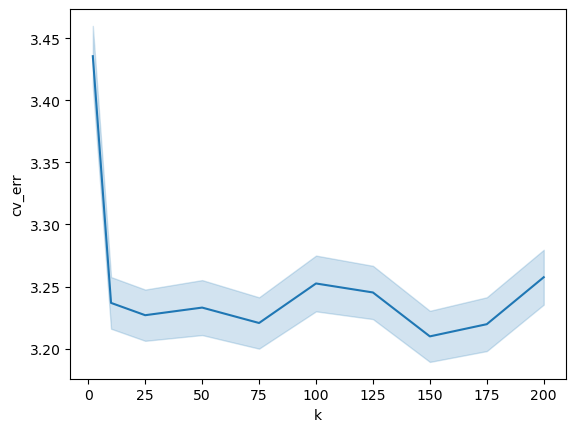

In [9]:
k_col = []
for k in ks:
    k_col.extend(niter*[k])
df = pd.DataFrame({"cv_err": lm_cv_errs.flatten(order='F'), "k": k_col})
ax_lm = sns.lineplot(x="k", y="cv_err", data=df, estimator="mean", errorbar="se")

In [10]:
## MC simulation: Decision tree model
dt = DecisionTreeRegressor(max_depth=4)

dt_cv_errs = np.zeros((niter, K))
for j, k in enumerate(ks):
    print(f"Iter:{j}, {k=}")
    cv = KFold(n_splits=k)
    for i in range(niter):
        dt_cv_errs[i,j] = compute_cv_est(n, beta, snr, dt, cv)

Iter:0, k=2
Iter:1, k=10
Iter:2, k=25
Iter:3, k=50
Iter:4, k=75
Iter:5, k=100
Iter:6, k=125
Iter:7, k=150
Iter:8, k=175
Iter:9, k=200


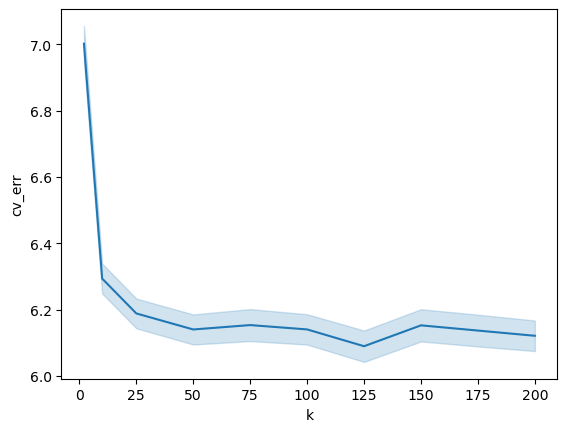

In [11]:
k_col = []
for k in ks:
    k_col.extend(niter*[k])
df = pd.DataFrame({"cv_err": dt_cv_errs.flatten(order='F'), "k": k_col})
ax_dt = sns.lineplot(x="k", y="cv_err", data=df, estimator="mean", errorbar="se")

For the two models, we see that the standard error of the CV estimate is rather constant with $k$. Perhaps there are other settings where you can make the effect even more exagerrated, perhaps by even introducing correlation in the samples (which is not at all unreasonable in quant finance), instead of i.i.d. like we have in our simulations. However, I think this make the point that the averaging over more folds does not always reduce variance, even when your data is i.i.d.